# Определение перспективного тарифа для телеком-компании

Заказчик - коммерческий департамент федерального оператора сотовой связи. С целью коррекции рекламного бюджета необходимо сравнить доходность предлагаемых клиентам тарифных планов.

**Цель исследования** - проанализировать поведение клиентов на основе выборки данных об активности 500 абонентов за 2018 год и определить наиболее доходный тариф.

**Ход исследования**

Данные представлены в виде пяти таблиц, содержащие данные о клиентах: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. При обзоре данных будет совершена проверка на возможные ошибки, которые могут помещать исследованию. После будет совершена предобработка данных с целью исправления ошибок и обработки пропущенных значений, при необходимости буду изменены типы данных и расчитаны дополнительные параметры. Затем на основе обработанных данных будет проведён статистический анализ данных. После будет совершена проверка сформированных заказчиком гипотез:
* Средняя выручка пользователей тарифов различаются.
* Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

По результатам будет сформирован общий вывод. 

Таким образом, исследование пройдёт в пять этапов:

 1. [**Обзор данных**](#overview)
 2. [**Предобработка данных**](#pre-proc)
 3. [**Анализ данных**](#analysis)
 4. [**Проверка гипотез**](#hypothesis)
 5. [**Общий вывод**](#conclusion)


<a id='overview'></a>

## Обзор данных

Сначали импортируем все необходимые таблицы с данными и рассмотрим каждую по отдельности.

In [1]:
# импортируем библиотеки для работы с данными

import os
import pandas as pd
import numpy as np
from scipy import stats as st
import seaborn as sns
import matplotlib.pyplot as plt

pd.options.display.float_format = '{:,.2f}'.format
sns.set_style('darkgrid')
sns.set(font_scale = 2)
plt.rcParams.update({'axes.labelsize': 15,'axes.titlesize': 25})
os.chdir('C:\\Users\\dmitr\\GitHub\\Practicum-Data-Analysis\\datasets\\')

In [2]:
# загружаем данные

users = pd.read_csv('users.csv') # таблица с информацией о пользователях
calls = pd.read_csv('calls.csv') # таблица с информацией о звонках
messages = pd.read_csv('messages.csv') # таблица с информацией о сообщениях
internet = pd.read_csv('internet.csv') # таблица с информацией об интернет-сессиях
tariffs = pd.read_csv('tariffs.csv') # таблица с информацией о тарифах

### Информация о пользователях

In [3]:
users.info() # выводим общую информацию о таблице
users.sample(5) # пять случайных строк таблицы

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
496,1496,36,NaN,Вологда,Трифон,Блохин,2018-01-27,smart
364,1364,74,NaN,Екатеринбург,Мстислав,Алексеенко,2018-08-29,ultra
86,1086,73,NaN,Волгоград,Ириней,Аксёнов,2018-04-26,smart
101,1101,27,NaN,Казань,Онисим,Колобов,2018-05-21,smart
293,1293,39,2018-11-22,Санкт-Петербург,Эдита,Дубинина,2018-09-05,smart


Таблица содержит 8 столбцов, содержащих 2 типа данных — `int64` и`object`.

Описание данных согласно документации:
* `user_id` — уникальный идентификатор пользователя
* `first_name` — имя пользователя
* `last_name` — фамилия пользователя
* `age` — возраст пользователя (годы)
* `reg_date` — дата подключения тарифа (день, месяц, год)
* `churn_date` — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
* `city` — город проживания пользователя
* `tariff` — название тарифного плана

**Выводы**
* Пропущенны значения в столбце `churn_date`, что в соответствии с документацией является нормой.
* Столбцы `reg_date` и `churn_date` содержат даты событий, но тип данных при этом `object`. В `churn_date` из-за пропусков данные не удастся привести к другому виду, в `reg_date` препятствий для преобразования нет.
* Для экономии ресурсов памяти можно привести данные типа `int64` к`int32`.
* Столбцы с именами клиентов скорее всего не пригодятся в исследовании, достаточно использования `user_id`.
* В `city` содержится город проживания абонента, в то время как одна из гипотез предпологает разделение на "Москва - не Москва" - этот столбец можно будет категоризовать для группировки данных.

### Информация о звонках

In [4]:
calls.info() # выводим общую информацию о таблице
calls.sample(5) # пять случайных строк таблицы

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


,id,call_date,duration,user_id
11532,1030_65,2018-07-24,8.83,1030
81435,1203_8,2018-06-13,0.00,1203
14380,1038_2,2018-10-23,5.54,1038
88405,1222_143,2018-12-13,14.50,1222
164530,1406_13,2018-12-29,5.80,1406


Таблица содержит 4 столбца, содержащих 3 типа данных — `float64`, `int64` и`object`.

Описание данных согласно документации:
* `id` — уникальный номер звонка
* `call_date` — дата звонка
* `duration` — длительность звонка в минутах (звонок с нулевой продолжительностью означает пропущенный вызов)
* `user_id` — идентификатор пользователя, сделавшего звонок

**Выводы**
* Явные пропуски в таблицу отсутствуют. `0` в `duration` означает пропущенный звонок.
* Столбец `call_date` содержат дату, но тип данных при этом `object`.
* Для экономии ресурсов памяти можно привести данные типа `int64` к`int32`.

### Информация о сообщениях

In [5]:
messages.info() # выводим общую информацию о таблице
messages.sample(5) # пять случайных строк таблицы

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


,id,message_date,user_id
55888,1247_30,2018-09-22,1247
57736,1253_245,2018-08-19,1253
3503,1014_120,2018-08-24,1014
107116,1432_48,2018-10-06,1432
30699,1134_417,2018-08-07,1134


Таблица содержит 3 столбца, содержащих 2 типа данных — `int64` и`object`.

Описание данных согласно документации:
* `id` — уникальный номер сообщения
* `message_date` — дата сообщения
* `user_id` — идентификатор пользователя, отправившего сообщение

**Выводы**
* В таблице отсутствуют пропущенные значения.
* Столбец `message_date` содержит дату, но тип данных при этом `object`.
* Для экономии ресурсов памяти можно привести данные типа `int64` к`int32`.

### Информация об интернет-сессиях

In [6]:
internet.info() # выводим общую информацию о таблице
internet.sample(5) # пять случайных строк таблицы

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


,Unnamed: 0,id,mb_used,session_date,user_id
80124,80124,1269_136,265.70,2018-07-28,1269
1000,1000,1004_220,503.99,2018-07-04,1004
39168,39168,1136_15,513.96,2018-12-06,1136
29621,29621,1104_38,814.85,2018-09-06,1104
144894,144894,1483_273,486.40,2018-08-21,1483


В таблице сохранён столбец с индексами - укажем его при чтении файла.

In [7]:
internet = pd.read_csv('internet.csv', index_col=0) # пересохраним переменную с указанием столбца
internet.info() # выводим общую информацию о таблице
internet.sample(5) # пять случайных строк таблицы

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            149396 non-null  object 
 1   mb_used       149396 non-null  float64
 2   session_date  149396 non-null  object 
 3   user_id       149396 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 5.7+ MB


,id,mb_used,session_date,user_id
40776,1143_274,705.41,2018-12-30,1143
112395,1380_524,750.18,2018-05-30,1380
86995,1294_337,742.57,2018-03-26,1294
25805,1089_97,337.14,2018-03-02,1089
148675,1496_623,199.03,2018-06-17,1496


Таблица содержит 5 столбцов, содержащих 3 типа данных — `float64`,`int64` и`object`.

Описание данных согласно документации:
* `id` — уникальный номер сессии
* `mb_used` — объём потраченного за сессию интернет-трафика (в мегабайтах)
* `session_date` — дата интернет-сессии
* `user_id` — идентификатор пользователя


**Выводы**
* Столбец `session_date` содержит дату, но тип данных при этом `object`.
* Для экономии ресурсов памяти можно привести данные типа `int64` к`int32`, столбец `mb_used` также можно привести к `int`, так для исследования нам не нужны доли мегабайтов.

### Информация о тарифах

In [8]:
tariffs.info() # выводим общую информацию о таблице
tariffs # выводим таблицу

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Таблица содержит 2 столбца, содержащих 2 типа данных — `int64` и`object`.

Описание данных согласно документации:
* `tariff_name` — название тарифа
* `rub_monthly_fee` — ежемесячная абонентская плата в рублях
* `minutes_included` — количество минут разговора в месяц, включённых в абонентскую плату
* `messages_included` — количество сообщений в месяц, включённых в абонентскую плату
* `mb_per_month_included` — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
* `rub_per_minute` — стоимость минуты разговора сверх тарифного пакета
* `rub_per_message` — стоимость отправки сообщения сверх тарифного пакета
* `rub_per_gb` — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

Описание тарифов:

**Тариф «Смарт»**

1. Ежемесячная плата: 550 рублей
2. Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
3. Стоимость услуг сверх тарифного пакета:
 * минута разговора: 3 рубля
 * сообщение: 3 рубля
 * 1 Гб интернет-трафика: 200 рублей

**Тариф «Ультра»**

1. Ежемесячная плата: 1950 рублей
2. Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
3. Стоимость услуг сверх тарифного пакета:
 * минута разговора: 1 рубль
 * сообщение: 1 рубль
 * 1 Гб интернет-трафика: 150 рублей

Согласно тарифным правилам, в звонках секунды округляются до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.
Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта. Неиспользованные за предыдущий месяц звонки, смс, интернет на следующий месяц не переносятся.

**Выводы**
* Данные о звонках и интернет сессиях округляются в большую сторону, что необходимо будет учесть при расчёте выручки от пользователей.
* В тарифах плата установлена за гигабайт траффика, но при этом сами сессии считаются в мегабайтах, данные о включенном трафике также представлены в мегабайтах.
* Для экономии ресурсов памяти можно привести данные типа `int64` к`int32`.

### Вывод

В ходе обзора данных были сделаны следующие выводы:

* Явных пропущенных значений в таблицах не обнаружено. Пропуски в `churn_date` таблицы `users` и  нулевые значения в таблице `call` оправданы (в соответствии с документацией).
* Во всех таблицах данные с датами представлены типом `object`. Это оправдано только в `churn_date` - из-за пропусков данные не удастся привести к другому виду, в остальных случаях препятствий для преобразования нет. Для исследования даты нужны только для группировки данных абонентов по месяцам - потому при образовании этих данных необходимо сразу получать номер месяца.
* Для экономии ресурсов памяти можно привести все данные типа `int64` к`int32`.
* Столбцы с именами клиентов скорее всего не пригодятся в исследовании, достаточно использования `user_id`.
* Данные о звонках и интернет сессиях округляются в большую сторону, что необходимо будет учесть при расчёте выручки от пользователей.
* В тарифах плата установлена за гигабайт траффика, но при этом сами сессии считаются в мегабайтах, данные о включенном трафике также представлены в мегабайтах.


<a id='pre-proc'></a>

## Предобработка данных

Данные в таблицах будут предобработаны отдельно, после чего будут произведены необходимые для исследования расчёты параметров и объединения. Начнём с информации о пользователях. 

### Подготовка данных

Начнём с информации об абонентах:

In [9]:
users.info() # ещё раз выведем общую информацию о таблице

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


Данные `churn_date` и `reg_date` могли бы быть использованы в исследовании - например, для установления зависимости расторжения контрактов клиентов от тарифа (предположительно в связи с неудовлетворительными условими). Создадим новый столбец `time_active` с данными о сроке использования тарифа:

In [10]:
# преобразуем данные столбцов в даты 

users['reg_date'] = pd.to_datetime(users['reg_date'])
users['churn_date'] = pd.to_datetime(users['churn_date'])

# количество дней использования тарифа

users['days_active'] = (
    (users['churn_date'] - users ['reg_date'])
    .dt.days
)

# имена абонентов нам не нужны, даты также больше не понадобятся - удалим лишние данные

users = users.drop(['first_name', 'last_name', 'reg_date','churn_date'], axis=1)

users[['user_id', 'age']] = users[['user_id', 'age']].astype('int32') # поменяем тип данных
users['days_active'] = users['days_active'].astype('Int32') # немного другой тип для столбца с пропусками

users.info() # выведем информацию об обновлённой таблице

# подсчитаем долю пропусков

na_share = round(users["days_active"].notna().sum()/len(users)*100, 2)
print(f'inactive client share is {na_share}%.')

users.describe() # описательная статистика

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      500 non-null    int32 
 1   age          500 non-null    int32 
 2   city         500 non-null    object
 3   tariff       500 non-null    object
 4   days_active  38 non-null     Int32 
dtypes: Int32(1), int32(2), object(2)
memory usage: 14.3+ KB
inactive client share is 7.6%.


,user_id,age,days_active
count,500.00,500.00,38.00
mean,"1,249.50",46.59,124.08
std,144.48,16.67,79.95
min,"1,000.00",18.00,5.00
25%,"1,124.75",32.00,58.50
50%,"1,249.50",46.00,105.50
75%,"1,374.25",62.00,192.25
max,"1,499.00",75.00,284.00


На основании получившейся таблицы уже можно сделать интересные выводы по выборке данных:
* Средний возраст абонентов - 46 лет
* 7.6% клиентов прекратили пользоваться выбранным тарифом в 2018 году.
* Из тех, кто больше не использует тариф, среднее время использование услуг составляет около 4 месяцев.

Напоследок попробуем визуализировать последний вывод в разрезе тарифов:

tariff
smart    23
ultra    15
Name: days_active, dtype: int64

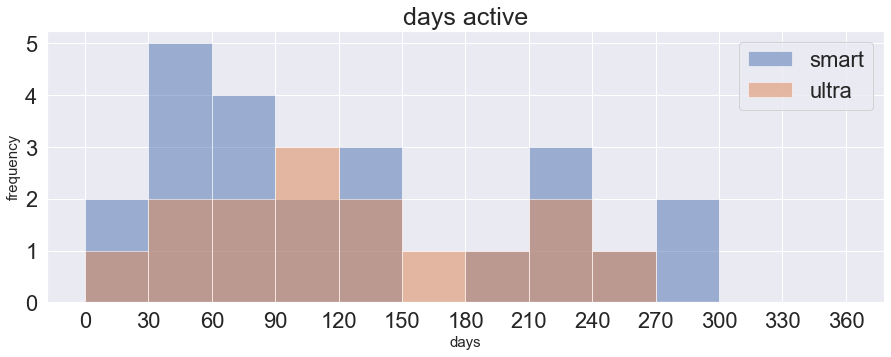

In [11]:
# создадим список интервалов для гистограммы, равным одному месяцу
interval = [0]
val = 0

for i in range(12):
    val += 30
    interval.append(val)
    
display(users.groupby('tariff')['days_active'].count()) # выведем распределение абонентов по тарифам

# изучим поведение абонентов с разными тарифами на гистограмме за год 
(users
 .groupby('tariff')['days_active']
 .plot(kind='hist', legend = True, bins=interval, figsize=[15,5], grid=True, alpha=0.5, xticks=interval)
)
plt.xlabel('days')
plt.ylabel('frequency')
plt.title('days active')
plt.show()


С учётом неравного распределение по тарифам, данных для серьезных выводов недостаточно (всего 7.6% процентов выборки из 500 человек). Но при этом всё равно можно заметить, что абоненты разных тарифов ведут себя по разному:
1. Большинство пользователи тарифа 'Смарт' отказываются от него в первые три месяца использования, пик приходится на второй месяц.
2. Распределение отказов от тарифа среди пользователей 'Ультра' более равномерно, пик приходится на четвёртый месяц.

Больше выводов из этих данных мы сделать не можем, а пропущенные значения могут помещать дальнейшим расчётам - удалим этот столбец и перейдём к следующей таблице:

In [12]:
users = users.drop('days_active', axis=1)

In [13]:
calls.info() # информация о звонках
calls.sample(10) # случайные 10 строк из таблицы

print(f'missed calls share is {round(calls[calls["duration"] == 0]["duration"].count()/len(calls)*100, 2)}%.')
# посчитаем  долю пропущенных звонков

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB
missed calls share is 19.55%.


Около 20% таблицы состявляют пропущенные звонки - в рамках исследования они могут понадобится для дополнительного характеризования поведение клиентов. Для исследования нам не нужны даты звонков - оставим только месяцы. Затем поменяем типы данных (данные о длительности звонков округлим в большую сторону, согласно документации).

In [14]:
calls['call_date'] = pd.to_datetime(calls['call_date']).dt.month.astype('int32')  # получим номер месяца
calls = calls.rename(columns={'call_date': 'month'}) # переименуем колонку

calls['duration'] = np.ceil(calls['duration']).astype('int32') 
# согласно правилам тарифов, все звонки округляются до целых минут в большую сторону

calls['user_id'] = calls['user_id'].astype('int32') # поменяем тип данных для экономии памяти

In [15]:
calls.sample(10) # случайные 10 строк из таблицы

,id,month,duration,user_id
177396,1438_73,11,0,1438
183550,1456_22,9,0,1456
77024,1193_286,11,24,1193
105433,1271_161,10,0,1271
100125,1255_9,6,1,1255
44193,1111_35,11,2,1111
76985,1193_247,6,0,1193
45630,1114_38,8,0,1114
61028,1154_46,10,3,1154
10655,1027_525,10,7,1027


In [16]:
calls.info() # снова посмотрим на информацию по таблице
calls['duration'].describe() # описательная статистика по столбцу с длительностью звонков

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        202607 non-null  object
 1   month     202607 non-null  int32 
 2   duration  202607 non-null  int32 
 3   user_id   202607 non-null  int32 
dtypes: int32(3), object(1)
memory usage: 3.9+ MB


count   202,607.00
mean          7.16
std           5.96
min           0.00
25%           2.00
50%           6.00
75%          11.00
max          38.00
Name: duration, dtype: float64

In [17]:
calls.groupby('user_id')['duration'].sum().describe() # посмотрим сколько разговаривают абоненты

count      492.00
mean     2,947.77
std      2,091.00
min         66.00
25%      1,291.50
50%      2,478.00
75%      4,227.00
max     12,973.00
Name: duration, dtype: float64

* Средняя длительность звонков всех абонентов составляет около 9 минут 
* За период использования тарифа в среднем каждый абонент разговаривает ~2,950 минут.



Переходим к следующему столбцу:

In [18]:
messages.info() # данные о сообщениях

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


Ситуация здесь похожа на таблицу с звонками. Изменим тип данных:

In [19]:
messages['message_date'] = pd.to_datetime(messages['message_date']).dt.month.astype('int32')  # получим номер месяца
messages = messages.rename(columns={'message_date': 'month'}) # переименуем колонку
messages['user_id'] = messages['user_id'].astype('int32') # поменяем тип данных для экономии памяти

messages.info() # снова выведем основную информацию

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   id       123036 non-null  object
 1   month    123036 non-null  int32 
 2   user_id  123036 non-null  int32 
dtypes: int32(2), object(1)
memory usage: 1.9+ MB


In [20]:
messages.info() # снова посмотрим на информацию по таблице
messages.groupby('user_id').count().describe() # посмотрим сколько абоненты отправляют сообщений

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   id       123036 non-null  object
 1   month    123036 non-null  int32 
 2   user_id  123036 non-null  int32 
dtypes: int32(2), object(1)
memory usage: 1.9+ MB


,id,month
count,426.00,426.00
mean,288.82,288.82
std,267.61,267.61
min,1.00,1.00
25%,85.75,85.75
50%,215.50,215.50
75%,414.00,414.00
max,"1,463.00","1,463.00"


* В среднем каждый абонент отправляет ~290 сообщений за весь период использования тарифа

Переходим дальше:

In [21]:
internet.info() # информация об интернет сессиях
internet.sample(10) # случайные 10 строк таблицы

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            149396 non-null  object 
 1   mb_used       149396 non-null  float64
 2   session_date  149396 non-null  object 
 3   user_id       149396 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 5.7+ MB


,id,mb_used,session_date,user_id
8460,1029_112,80.21,2018-11-05,1029
9048,1032_128,376.68,2018-01-18,1032
108089,1369_118,220.61,2018-10-04,1369
138912,1466_52,489.90,2018-05-14,1466
24348,1083_228,738.43,2018-12-16,1083
24441,1083_321,700.43,2018-09-01,1083
119759,1403_314,316.87,2018-11-18,1403
25065,1086_272,697.14,2018-08-22,1086
131277,1436_243,343.78,2018-12-25,1436
103053,1345_232,0.00,2018-08-19,1345


Количество использованного трафика округлим до гигабайт - именно они используются для расчётов в тарифах. Затем изменим тип данных последних двух столбцов:

In [22]:
internet['session_date'] = pd.to_datetime(internet['session_date']).dt.month.astype('int32')  # получим номер месяца
internet['user_id'] = internet['user_id'].astype('int32') # поменяем тип данных для экономии памяти
internet['mb_used'] = internet['mb_used']/1024 # округлим данные до гигабайт
internet = internet.rename(columns={'mb_used': 'gb_used','session_date':'month'}) # переименуем колонки

internet.info() # снова выведем основную информацию
internet.describe() # описательная статистика по использованию трафика

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       149396 non-null  object 
 1   gb_used  149396 non-null  float64
 2   month    149396 non-null  int32  
 3   user_id  149396 non-null  int32  
dtypes: float64(1), int32(2), object(1)
memory usage: 4.6+ MB


,gb_used,month,user_id
count,"149,396.00","149,396.00","149,396.00"
mean,0.36,8.56,"1,252.10"
std,0.27,2.79,144.05
min,0.00,1.00,"1,000.00"
25%,0.13,7.00,"1,130.00"
50%,0.34,9.00,"1,251.00"
75%,0.55,11.00,"1,380.00"
max,1.68,12.00,"1,499.00"


In [23]:
internet.groupby('user_id')['gb_used'].sum().describe() # статистика использования интернета по пользователям

count   497.00
mean    108.67
std      68.72
min       4.50
25%      53.18
50%      98.77
75%     149.89
max     367.58
Name: gb_used, dtype: float64

* Средний трафик сессия состявляет 0.36 гигабайт.
* Абоненты в период использования тарифа тратят в среднем ~109 гигабайт.

Трафик сессий, как и звонки, должен быть округлён в большую сторону, но это происходит в разрезе месяцев для каждого пользователя - оставим для трафика тип данных `float`, округлим при объединении данных.

Переходим к последней таблице:

In [24]:
tariffs.info() # информация о тарифах
tariffs # сама таблица

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Таблица в порядке - нужно лишь округлить `mb_per_month_included` до гигабайт, чтобы все расчёты можно было проводить с использование единых мер исчисления, а также сократить название колонки `tariff_name` до `tariff` - так она будет совпадать с идентичной колонкой в `users`, что позволит их потом объединить:

In [25]:
tariffs['mb_per_month_included'] = tariffs['mb_per_month_included']/1024 # округлим данные до гигабайт

# переименуем колонки
tariffs = (tariffs
           .rename(columns={'mb_per_month_included': 'gb_per_month_included', 'tariff_name':'tariff'})
          )
                
tariffs[['messages_included', 'gb_per_month_included', 'minutes_included', 'rub_monthly_fee','rub_per_gb', 
         'rub_per_message', 'rub_per_minute']]\
= tariffs[['messages_included', 'gb_per_month_included', 'minutes_included','rub_monthly_fee', 
                    'rub_per_gb', 'rub_per_message', 'rub_per_minute']].astype('int32') # поменяем тип данных

tariffs # снова выводим таблицу

,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff
0,50,15,500,550,200,3,3,smart
1,1000,30,3000,1950,150,1,1,ultra


Все данные обработаны, теперь их можно комбинировать между собой.

### Объединение данных

Для оптимизации дальнейшего исследования данные всех таблиц будут объеденены в единый датафрейм. Сначала таблицы с данными о звонках, сообщениях и интернет сессиях будут сгруппированы по идентификатору пользователя и месяцу, после чего будут последовательно объединены с информацией об абонентах:

In [26]:
#группируем данные о звонках

calls_pivot = (calls
               .pivot_table(index=['user_id', 'month'], values='duration', aggfunc=['count','sum'])
               .droplevel(1,axis=1)
               .rename(columns={'count':'calls','sum':'calls_duration'})
               .reset_index()
              )
                                                                                                    
# группируем данные о сообщениях

msg_pivot = (messages
                  .pivot_table(index=['user_id', 'month'], values='id', aggfunc='count')
                  .rename(columns={'id':'messages'})
                  .reset_index()
            )

# групируем данные о сообщениях

int_pivot = (internet
            .pivot_table(index=['user_id', 'month'], values='gb_used', aggfunc='sum')
            .reset_index()
            )

# начинаем объединение


data = users.merge(calls_pivot, on='user_id', how='left') # соединяем данные о пользователях и звонках
data = data.merge(msg_pivot, on=['user_id', 'month'], how='left') # прибавляем сообщения
data = data.merge(int_pivot, on=['user_id', 'month'], how='left') # интернет-сессии
data = data.merge(tariffs, on=['tariff'], how='left') # информация о тарифах

display(data.head(15)) # посмотрим на первые 15 строк
print(f'user count is {data["user_id"].value_counts().count()}') # убедимся, что все абоненты на месте
data.isna().sum() # проверим пропуски

,user_id,age,city,tariff,month,calls,calls_duration,messages,gb_used,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,52,Краснодар,ultra,5.00,22.00,159.00,22.00,2.20,1000,30,3000,1950,150,1,1
1,1000,52,Краснодар,ultra,6.00,43.00,172.00,60.00,22.69,1000,30,3000,1950,150,1,1
2,1000,52,Краснодар,ultra,7.00,47.00,340.00,75.00,13.68,1000,30,3000,1950,150,1,1
3,1000,52,Краснодар,ultra,8.00,52.00,408.00,81.00,13.73,1000,30,3000,1950,150,1,1
4,1000,52,Краснодар,ultra,9.00,58.00,466.00,57.00,14.23,1000,30,3000,1950,150,1,1
5,1000,52,Краснодар,ultra,10.00,57.00,350.00,73.00,14.36,1000,30,3000,1950,150,1,1
6,1000,52,Краснодар,ultra,11.00,43.00,338.00,58.00,14.41,1000,30,3000,1950,150,1,1
7,1000,52,Краснодар,ultra,12.00,46.00,333.00,70.00,9.59,1000,30,3000,1950,150,1,1
8,1001,41,Москва,smart,11.00,59.00,430.00,NaN,18.00,50,15,500,550,200,3,3
9,1001,41,Москва,smart,12.00,63.00,414.00,NaN,13.71,50,15,500,550,200,3,3


user count is 500


user_id                    0
age                        0
city                       0
tariff                     0
month                      8
calls                      8
calls_duration             8
messages                 504
gb_used                   19
messages_included          0
gb_per_month_included      0
minutes_included           0
rub_monthly_fee            0
rub_per_gb                 0
rub_per_message            0
rub_per_minute             0
dtype: int64

Проверим каждый столбец:

In [27]:
print(f'na share is {round(len(data[data["month"].isna()])/len(data)*100, 2)}%') # доля пропусков в месяцах
data[data['month'].isna()] # посмотрим на пропуски в месяцах

na share is 0.25%


,user_id,age,city,tariff,month,calls,calls_duration,messages,gb_used,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
570,1091,36,Набережные Челны,ultra,NaN,NaN,NaN,NaN,NaN,1000,30,3000,1950,150,1,1
664,1106,67,Калуга,ultra,NaN,NaN,NaN,NaN,NaN,1000,30,3000,1950,150,1,1
812,1128,51,Волжский,ultra,NaN,NaN,NaN,NaN,NaN,1000,30,3000,1950,150,1,1
1460,1231,63,Чебоксары,ultra,NaN,NaN,NaN,NaN,NaN,1000,30,3000,1950,150,1,1
2061,1328,44,Мурманск,ultra,NaN,NaN,NaN,NaN,NaN,1000,30,3000,1950,150,1,1
2311,1371,50,Омск,smart,NaN,NaN,NaN,NaN,NaN,50,15,500,550,200,3,3
3022,1473,18,Красноярск,ultra,NaN,NaN,NaN,NaN,NaN,1000,30,3000,1950,150,1,1
3121,1489,35,Санкт-Петербург,smart,NaN,NaN,NaN,NaN,NaN,50,15,500,550,200,3,3


Всего восемь строк, в них кроме месяцев также пропущенны данные о звонках, сообщениях и интернет сессиях - эти абоненты как-будто просто не пользуются услугами, продолжая при этом платить за тариф. Все недостающие данные, можно было бы заполнить медианой по тарифам, за исключением месяца. Поскольку нам важна группировка по месяцам в таблице и принимая во внимание небольшую долю таких данных, целесообразнее будет от них избавиться: 

In [28]:
data = data[data['month'].notna()] # удаляем данные с пропущенными месяцами

data[data['messages'].isna()] # смотрим на пропуски в сообщениях

,user_id,age,city,tariff,month,calls,calls_duration,messages,gb_used,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
8,1001,41,Москва,smart,11.00,59.00,430.00,NaN,18.00,50,15,500,550,200,3,3
9,1001,41,Москва,smart,12.00,63.00,414.00,NaN,13.71,50,15,500,550,200,3,3
42,1006,21,Ульяновск,smart,2.00,3.00,42.00,NaN,1.36,50,15,500,550,200,3,3
43,1006,21,Ульяновск,smart,3.00,46.00,286.00,NaN,16.88,50,15,500,550,200,3,3
44,1006,21,Ульяновск,smart,4.00,47.00,356.00,NaN,13.61,50,15,500,550,200,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3149,1494,62,Омск,smart,8.00,32.00,262.00,NaN,6.44,50,15,500,550,200,3,3
3150,1494,62,Омск,smart,9.00,66.00,501.00,NaN,16.56,50,15,500,550,200,3,3
3151,1494,62,Омск,smart,10.00,52.00,354.00,NaN,17.35,50,15,500,550,200,3,3
3152,1494,62,Омск,smart,11.00,63.00,411.00,NaN,17.63,50,15,500,550,200,3,3


Это явно активные пользователи, которые просто не использовали сообщения в определённые месяцы - с учётом распространения совсременных мессенджеров, работающих через интернет - такое вполне вероятно. Заполним пропуски нулевыми значениями:

In [29]:
data['messages'] = data['messages'].fillna(0) # заполняем пропуски

data[data['gb_used'].isna()] # смотрим пропуски в данных об интернет сессиях

,user_id,age,city,tariff,month,calls,calls_duration,messages,gb_used,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
1701,1273,46,Курган,ultra,5.00,24.00,220.00,21.00,NaN,1000,30,3000,1950,150,1,1
1702,1273,46,Курган,ultra,6.00,40.00,230.00,38.00,NaN,1000,30,3000,1950,150,1,1
1703,1273,46,Курган,ultra,7.00,44.00,253.00,37.00,NaN,1000,30,3000,1950,150,1,1
1704,1273,46,Курган,ultra,8.00,53.00,253.00,41.00,NaN,1000,30,3000,1950,150,1,1
1705,1273,46,Курган,ultra,9.00,33.00,223.00,32.00,NaN,1000,30,3000,1950,150,1,1
1706,1273,46,Курган,ultra,10.00,40.00,315.00,35.00,NaN,1000,30,3000,1950,150,1,1
1707,1273,46,Курган,ultra,11.00,45.00,272.00,29.00,NaN,1000,30,3000,1950,150,1,1
1708,1273,46,Курган,ultra,12.00,41.00,260.00,39.00,NaN,1000,30,3000,1950,150,1,1
2364,1377,59,Брянск,ultra,2.00,23.00,179.00,2.00,NaN,1000,30,3000,1950,150,1,1
2477,1392,54,Челябинск,ultra,2.00,2.00,13.00,3.00,NaN,1000,30,3000,1950,150,1,1


Тут тоже самое - пользователи активно пользуются услугами, но в какие-то месяцы не расходуют трафик - скорее всего пользуются для интернета другими устройствами. Причём большая часть пропусков у `user_id 1273` - он не пользуется интернетом несколько месяцев подряд. Судя по остальным данным - для него тариф "Смарт" был бы более оптимальным.

Заполним пропуски нулевыми значениями:

In [30]:
data['gb_used'] = data['gb_used'].fillna(0) # заполняем пропуски

data.isna().sum() # снова проверяем пропуски по таблице

user_id                  0
age                      0
city                     0
tariff                   0
month                    0
calls                    0
calls_duration           0
messages                 0
gb_used                  0
messages_included        0
gb_per_month_included    0
minutes_included         0
rub_monthly_fee          0
rub_per_gb               0
rub_per_message          0
rub_per_minute           0
dtype: int64

Пропущенные значения обработаны. Теперь проверим типы данных:

In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3174 entries, 0 to 3181
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   user_id                3174 non-null   int32  
 1   age                    3174 non-null   int32  
 2   city                   3174 non-null   object 
 3   tariff                 3174 non-null   object 
 4   month                  3174 non-null   float64
 5   calls                  3174 non-null   float64
 6   calls_duration         3174 non-null   float64
 7   messages               3174 non-null   float64
 8   gb_used                3174 non-null   float64
 9   messages_included      3174 non-null   int32  
 10  gb_per_month_included  3174 non-null   int32  
 11  minutes_included       3174 non-null   int32  
 12  rub_monthly_fee        3174 non-null   int32  
 13  rub_per_gb             3174 non-null   int32  
 14  rub_per_message        3174 non-null   int32  
 15  rub_

Из-за появившихся пропусков часть данных представлена как `float`. Так как пропуски уже обработаны, мы можем привести данные к целым числам:

In [32]:
data[['month','calls', 'calls_duration', 'messages']] \
= data[['month','calls', 'calls_duration', 'messages']].astype('int32') # меняем тип данных

data['gb_used'] = np.ceil(data['gb_used']).astype('int32')  # меняем тип данных

Категоризуем столбец `city`, чтобы можно было группировать данные для проверки гипотез:

In [33]:
def city_type(name): # напишем функцию для присвоения категории в соответствии с типом городом
    
    if 'Москва' in name:
        return 'moscow' # категория для Москвы
    else:
        return 'other' # остальные города
data['city_type'] = data['city'].apply(city_type)    

Теперь добавим помесячную выручку на каждого пользователя:

In [34]:
# добавим столбцы с перерасходом объёма услуг, включенных в тариф

data['extra_minutes']  = data['calls_duration'] - data['minutes_included'] # минуты разговора сверх пакета
data['extra_messages']  = data['messages'] - data['messages_included'] # сообщения сверх пакета
data['extra_traffic']  = data['gb_used'] - data['gb_per_month_included'] # трафик сверх пакета

# поставим 0 для тех, кто уложился в тарифный пакет

data.loc[(data['extra_minutes'] < 0), 'extra_minutes'] = 0
data.loc[(data['extra_messages'] < 0), 'extra_messages'] = 0
data.loc[(data['extra_traffic'] < 0), 'extra_traffic'] = 0

# считаем выручку за перерасход пакетов

call_rev = data['extra_minutes'] * data['rub_per_minute'] # выручка за перерасход по звонкам
msg_rev = data['extra_messages'] * data['rub_per_message'] # выручка за перерасход по сообщениям
int_rev = data['extra_traffic'] * data['rub_per_gb'] # выручка за перерасход трафика

#добавляем результаты в таблицу

data['extra_revenue'] = (call_rev + msg_rev + int_rev) # добавим столбец с выручкой по перерасходу пакетов
data['total_revenue'] = data['extra_revenue'] + data['rub_monthly_fee'] # общая выручка

In [35]:
data = data.set_index(['user_id', 'month']) # сгруппируем данные по абонентам и месяцам
data.info() # общая информация
data.head(20) # первые 20 строк финальной таблицы

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3174 entries, (1000, 5) to (1499, 12)
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   age                    3174 non-null   int32 
 1   city                   3174 non-null   object
 2   tariff                 3174 non-null   object
 3   calls                  3174 non-null   int32 
 4   calls_duration         3174 non-null   int32 
 5   messages               3174 non-null   int32 
 6   gb_used                3174 non-null   int32 
 7   messages_included      3174 non-null   int32 
 8   gb_per_month_included  3174 non-null   int32 
 9   minutes_included       3174 non-null   int32 
 10  rub_monthly_fee        3174 non-null   int32 
 11  rub_per_gb             3174 non-null   int32 
 12  rub_per_message        3174 non-null   int32 
 13  rub_per_minute         3174 non-null   int32 
 14  city_type              3174 non-null   object
 15  extra_m

age         city tariff  calls  calls_duration  messages  \
user_id month                                                             
1000    5       52    Краснодар  ultra     22             159        22   
        6       52    Краснодар  ultra     43             172        60   
        7       52    Краснодар  ultra     47             340        75   
        8       52    Краснодар  ultra     52             408        81   
        9       52    Краснодар  ultra     58             466        57   
        10      52    Краснодар  ultra     57             350        73   
        11      52    Краснодар  ultra     43             338        58   
        12      52    Краснодар  ultra     46             333        70   
1001    11      41       Москва  smart     59             430         0   
        12      41       Москва  smart     63             414         0   
1002    6       59  Стерлитамак  smart     15             117         4   
        7       59  Стерлитамак  smart     26             214        11   
        8       59  Стерлитамак  smart     42             289        13   
        9       59  Стерлитамак  smart     36             206         4   
        10      59  Стерлитамак  smart     33             212        10   
        11      59  Стерлитамак  smart     32             243        16   
        12      59  Стерлитамак  smart     33             236        12   
1003    8       23       Москва  ultra     55             380        37   
        9       23       Москва  ultra    134             961        91   
        10      23       Москва  ultra    108             855        83   

               gb_used  messages_included  gb_per_month_included  \
user_id month                                                      
1000    5            3               1000                     30   
        6           23               1000                     30   
        7           14               1000                     30   
        8           14               1000                     30   
        9           15               1000                     30   
        10          15               1000                     30   
        11          15               1000                     30   
        12          10               1000                     30   
1001    11          18                 50                     15   
        12          14                 50                     15   
1002    6           11                 50                     15   
        7           18                 50                     15   
        8           20                 50                     15   
        9           17                 50                     15   
        10          14                 50                     15   
        11          19                 50                     15   
        12          18                 50                     15   
1003    8            9               1000                     30   
        9           13               1000                     30   
        10          15               1000                     30   

               minutes_included  rub_monthly_fee  rub_per_gb  rub_per_message  \
user_id month                                                                   
1000    5                  3000             1950         150                1   
        6                  3000             1950         150                1   
        7                  3000             1950         150                1   
        8                  3000             1950         150                1   
        9                  3000             1950         150                1   
        10                 3000             1950         150                1   
        11                 3000             1950         150                1   
        12                 3000             1950         150                1   
1001    11                  500              550         

### Вывод

Каждая таблица была подробно изучена, лишние для исследования данные были удалены, произведены необходимые изменения типов данных. В ходе предобработки были сделаны следующие выводы:

* Средний возраст абонентов - 46 лет
* 7.6% клиентов прекратили пользоваться выбранным тарифом в 2018 году.
* Из тех, кто больше не использует тариф, среднее время использование услуг составляет около 4 месяцев.

* Абоненты, в течении года отказавшиеся от услуг оператора,в зависимости от тарифа ведут себя по разному:
 1. Большинство пользователи тарифа 'Смарт' отказываются от него в первые три месяца использования, пик приходится на второй месяц.
 2. Распределение отказов от тарифа среди пользователей 'Ультра' более равномерно, пик приходится на четвёртый месяц.



* Средняя длительность звонков всех абонентов составляет около 9 минут 
* За период использования тарифа в среднем каждый абонент разговаривает ~2,800 минут.

* В среднем каждый абонент отправляет ~290 сообщений за весь период использования тарифа

* Средний трафик сессии состявляет 0.36 гигабайт.
* Абоненты в период использования тарифа тратят в среднем ~109 гигабайт.

После данные были объединены в единую таблицу `data` и сгруппированы по идентификатору пользователя и месяцам, появившиеся в ходе объединения пропуски были обработаны. Затем были расчитаны дополнительные параметры с объёмом перерасхода тарифного пакета, выручкой по перерасходу и общей выручкой. Таким образом в нашем распоряжении есть данные, показывающие всю информацию в разрезе месяцев для каждого пользователя - именно эта таблица станет основой для дальнейшего исследования.

<a id='analysis'></a>

## Анализ данных

Анализ данных будет проходить в виде сравнения данных в разрезе тарифов. Сначала буду сопоставлена объёмы использования услуг операторов, затем буду построены графики распределения этих значений.

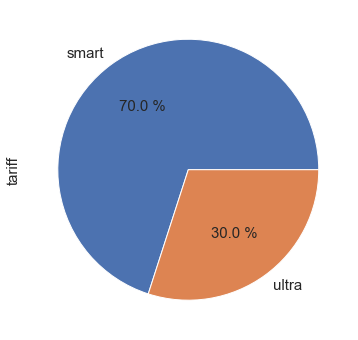

In [36]:
# визуализируем долю тарифов в выборке

(
    data['tariff']
    .value_counts()
    .plot(kind='pie', autopct='%1.1f %%', 
          figsize=[15,6], textprops=dict(fontsize='15'))
) 
plt.show()

Поскольку распределение абонентов по тарифам в выборке неравное, сравнивать абсолютные значения выручки будет непоказательно. Основным источником данных для анализа будут среднемесячные данные об объёме использованных услуг.

### Сравнение объёмов использования услуг

Сравним использование услуг в разрезе тарифов:

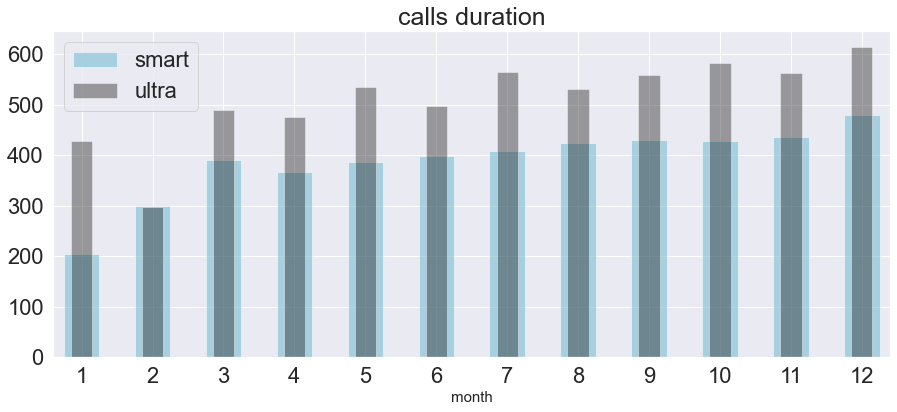

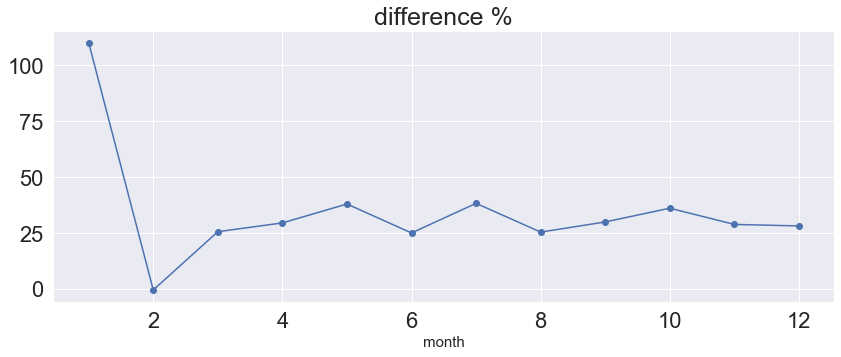

In [37]:
# отберём и сгруппируем необходимые данные из общей таблицы

smart_pivot = (data[data['tariff'] == 'smart']
                 .pivot_table
                 (index=['month'], values=['calls_duration', 
                                           'messages', 'gb_used'])
                )
ultra_pivot = (data[data['tariff'] == 'ultra']
                 .pivot_table
                 (index=['month'], values=['calls_duration', 
                                           'messages', 'gb_used'])
                )

def compare(parameter): # напишем функцию для построения столбчатой диаграммы и графика разницы значений в %
    
    ax = (smart_pivot
          .plot(y=parameter, kind='bar', 
                label='smart', alpha=0.5, color ='c')
         )
    (ultra_pivot
     .plot(y=parameter, kind='bar', 
           label='ultra', figsize=(15, 6), 
           ax=ax, alpha=0.4, color = 'k', width=0.3, title='calls duration')
    )
    plt.xticks(rotation = 0)
    plt.show()
    
    # график ниже покажет насколько абоненты тарифа "Ультра" больше или меньше пользуются услугами
    
    pivot_difference = (ultra_pivot[parameter]-smart_pivot[parameter])/smart_pivot[parameter]*100
    pivot_difference.plot(style='o-', figsize=(14,5), title='difference %')
    plt.show()
    
compare('calls_duration') # сравним длительность звонков

В целом абонента "Ультра", что ожидаемо, более активно пользуются сотовой связью. За исключением февраля, где средняя продолжительность звонков у обоих групп одинакова, среднемесячная продолжительность разговора абонентов "Ультра" выше. На втором графике видно, что показатель января в два раза выше тарифа "Смарт", по остальным месяцам разница составляет около 30% в пользу "Ультра". Пик обоих значений приходится на декабрь. Минимальные значения - 200 минут для абонентов "Смарт" (январь) и 300 минут для "Ультра" (февраль).

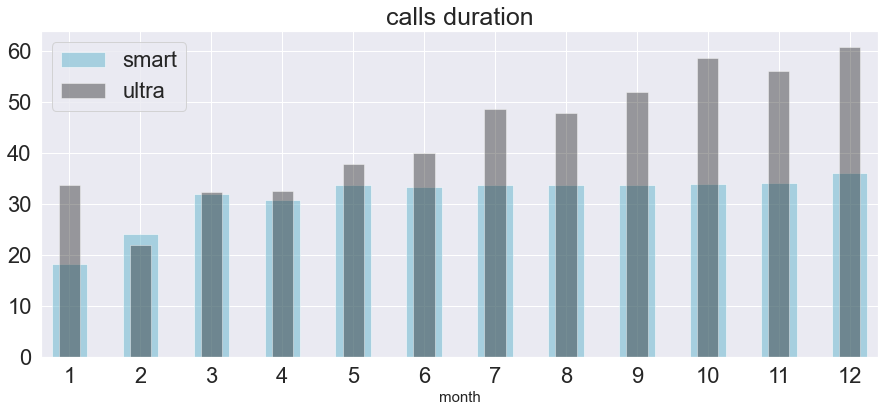

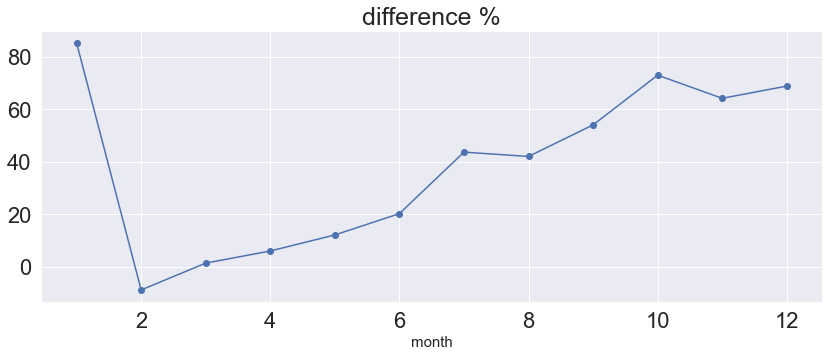

In [38]:
compare('messages') # сравним количество сообщенией

Тариф "Ультра" преобладает и здесь. Ситуация в первые два месяца очень похоже на данные звонков - в январе количество сообщений от пользователей "Ультра" больше почти в два раза, тогда как в феврале объём сообщений сопоставим, что также является низшей точкой для обеих групп (примерно 20 сообщений).
Дальше количество сообщений в тарифе "Смарт" находится примерно на одном уровне до конца года (~30), а вот объём сообщений тарифа "Ультра" с каждым месяцем вырастает, постепенно увеличивая разрыв с тарифом "Смарт". Пиком для обоих групп здесь также можно обозначить декабрь (хотя у тарифа "Смарт" идентичный показатель также находится в июне).

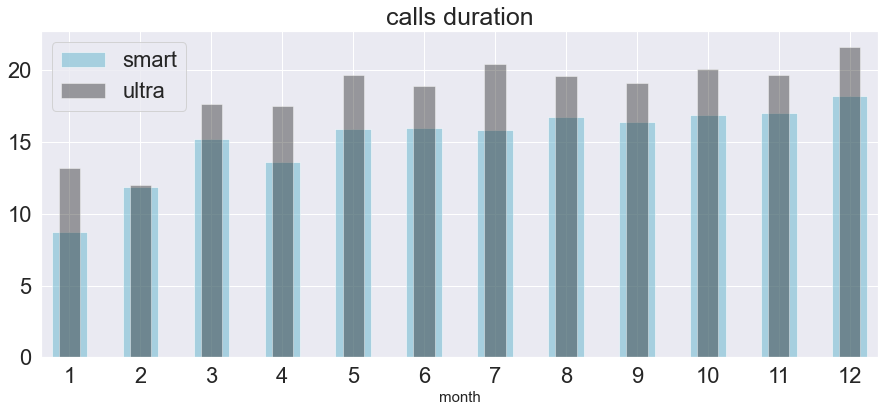

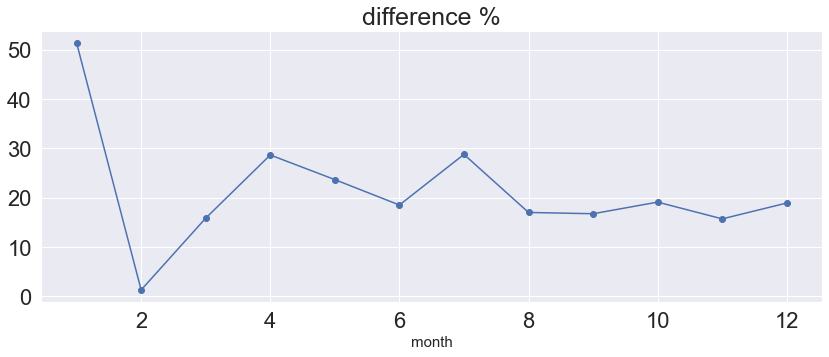

In [39]:
compare('gb_used') # сравним трафик интернет-сессий

Визуально оба графика идентичны картине по длительности звонков - большая разница в пользу "Ультра" в январе, провал в феврале, где оба показателя на одном уровне, затем относительно равномерное распределение по оставшимся месяцам, с разницей на уровне 20-30% в сторону "Ультра". Пиковым значением для обоих групп также является декабрь, минимальный размер трафика для "Смарт" - 7.5 гб (январь), для "Ультра" - примерно 11 гб (февраль).

**Выводы**

При сравнении среднемесячных данных о продолжительности звонков, количестве сообщений и объёма трафика в разрезе тарифов были сделаны следующие выводы:

* несмотря на меньшую долю в выборке (30%), абоненты тарифа "Ультра" намного активнее пользуются услугами оператора.
* пик объёма использованных услуг для обоих тарифов приходится на декабрь, минимальные значения - на январь-февраль
* в январе объём услуг "Ультра" сильно превышает "Смарт" (для части данных - в два раза), в феврале происходит резкий спад, где объёмы услуг для обоих тарифов уравниваются.
* минимальная продолжительность разговора - 200 минут для абонентов "Смарт" и 300 минут для "Ультра".
* минимальное количество отправленных сообщений для обоих тарифов - около 20 сообщений.
* минимальный размер интернет трафика для "Смарт" - 7.5 гб (январь), для "Ультра" - примерно 11 гб (февраль).

Динамика распределения данных по месяцам для звонков и интернет-трафика: 
 * Большая разница в пользу "Ультра" в январе, провал в феврале, где оба показателя на одном уровне, затем относительно равномерное распределение по оставшимся месяцам, с разницей на уровне 20-30% в сторону "Ультра". Пиковым значением для обоих групп является декабрь.
 
Динамика по количеству сообщений:

 * В январе количество сообщений от пользователей "Ультра" больше почти в два раза, тогда как в феврале объём сообщений сопоставим, что также является низшей точкой для обеих групп. Дальше количество сообщений в тарифе "Смарт" находится примерно на одном уровне до конца года, а вот объём сообщений тарифа "Ультра" с каждым месяцем вырастает, постепенно увеличивая разрыв с тарифом "Смарт". Пиком для обоих групп здесь также можно обозначить декабрь (хотя у тарифа "Смарт" идентичный показатель также находится в июне).

### Распределение данных

Расчитаем дополнительные показатели и визуализируем распределение по данным каждого тарифа:

In [40]:
# отберём и сгруппируем необходимые данные из общей таблицы

smart_pivot = (data[data['tariff'] == 'smart']
                 .pivot_table
                 (index=['user_id'], values=['calls_duration', 'messages', 'gb_used'])
                )
ultra_pivot = (data[data['tariff'] == 'ultra']
                 .pivot_table
                 (index=['user_id'], values=['calls_duration', 'messages', 'gb_used'])
                )

# расчитаем среднее, стандартное отклонение и дисперсию для каждой услуги

calls_distr = (data
               .pivot_table(index=['tariff'], values='calls_duration', aggfunc=['mean', 'std', 'var'])
               .droplevel(1, axis=1)
                )

messages_distr = (data
                 .pivot_table(index=['tariff'], values='messages', aggfunc=['mean', 'std', 'var'])
                  .droplevel(1, axis=1)
                )
traffic_distr = (data
                 .pivot_table(index=['tariff'], values='gb_used', aggfunc=['mean', 'std', 'var'])
                 .droplevel(1, axis=1)
                )

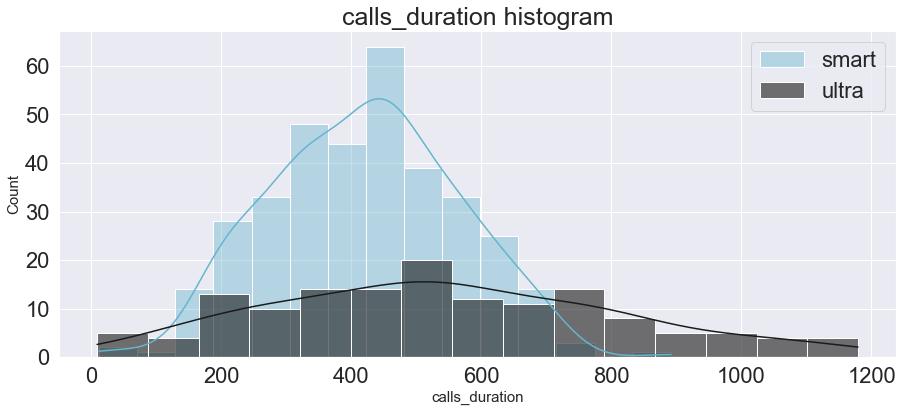

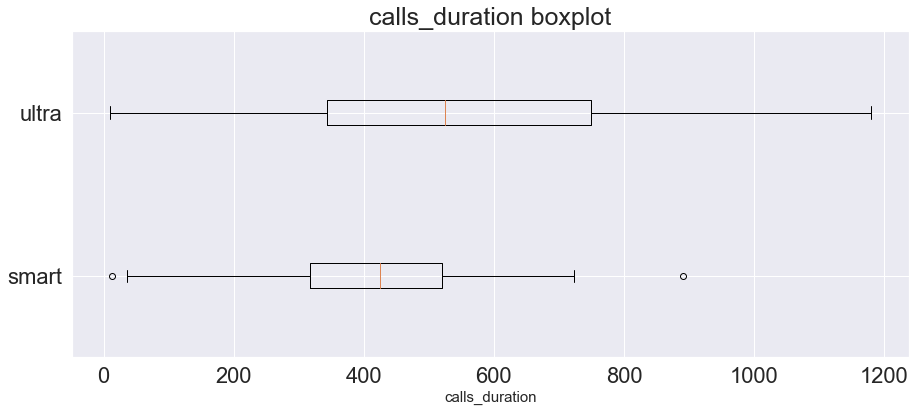

,mean,std,var
tariff,,,
smart,419.06,189.33,"35,844.19"
ultra,545.45,306.93,"94,203.42"


In [41]:
# напишем функцию для анализа распределения средних значений.

def distribution(parameter):
    
    smart = smart_pivot[parameter]
    ultra = ultra_pivot[parameter]
    
    # строим гистограмму
    
    plt.figure(figsize=[15,6])
    
    sns.histplot(smart, alpha=0.4, 
                 legend=True, label='smart', 
                 bins=15, color='c', kde=True)
    
    sns.histplot(ultra, alpha=0.6, 
                 legend=True, label='ultra', 
                 bins=15, color='k', kde=True)
    
    plt.title(parameter + ' ' + 'histogram')
    plt.legend()
    plt.show()
    plt.close()
    
    # строим диаграмму размаха
    
    plt.figure(figsize=[15,6])
    plt.boxplot([smart, ultra], labels=['smart', 'ultra'], vert=False)
    plt.xlabel('calls_duration')
    plt.title(parameter + ' ' + 'boxplot')
    plt.show()
   
    
# посмотрим на данные о звонках
    
distribution('calls_duration')
calls_distr 

Оба тарифа демонстируют нормальное распределение, но при этом они сильно отличаются по ширине. Это обусловлено высоким уровнем стандартного отклонения и дисперсии у тарифа "Ультра" - эти показатели почти в три раза превышают показатели "Смарт", при том что средние значения тарифов не имеют настолько значительной разницы. Диаграмма размаха демонстрирует выбросы по обе стороны квартилей для тарифа "Смарт", а значения тарифа "Ультра" целиком находятся в пределах нормального распределения. Это всё говорит о том, что поведение абонентов "Ультра" намного сложнее предсказать.

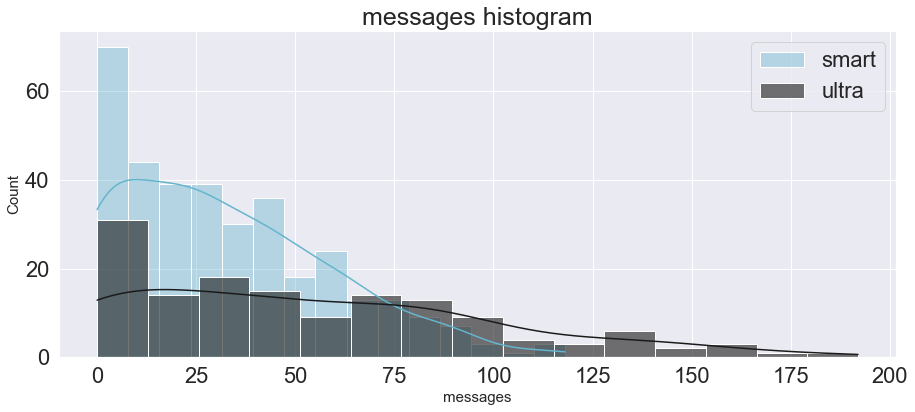

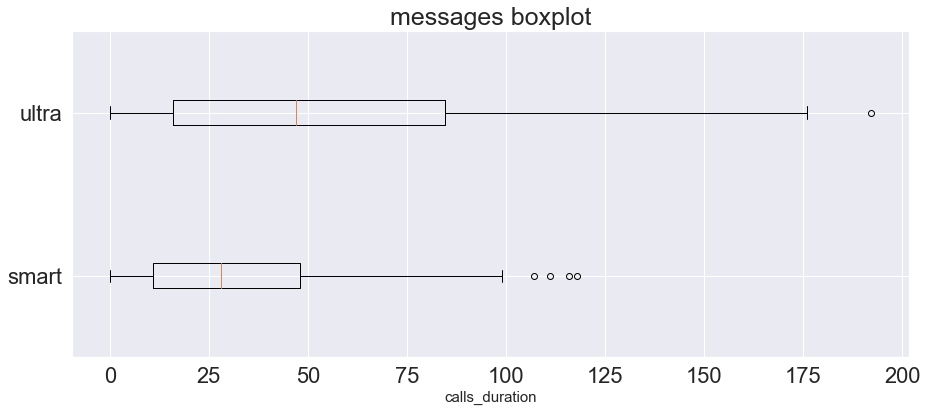

,mean,std,var
tariff,,,
smart,33.40,28.26,798.60
ultra,49.03,46.89,"2,198.73"


In [42]:
# посмотрим на данные о сообщениях
    
distribution('messages')
messages_distr 

Оба графика имеют сильную отрицательную скошенность. Визуально напоминают распределение Пуассона. Средние показатели практически равны стандартному отклонению, что говорит о сильной неравномерности распределения данных. Оба тарифа также имеются выбросы за пределами третьего квартиля, в значительно большем объёме для тарифа "Смарт".

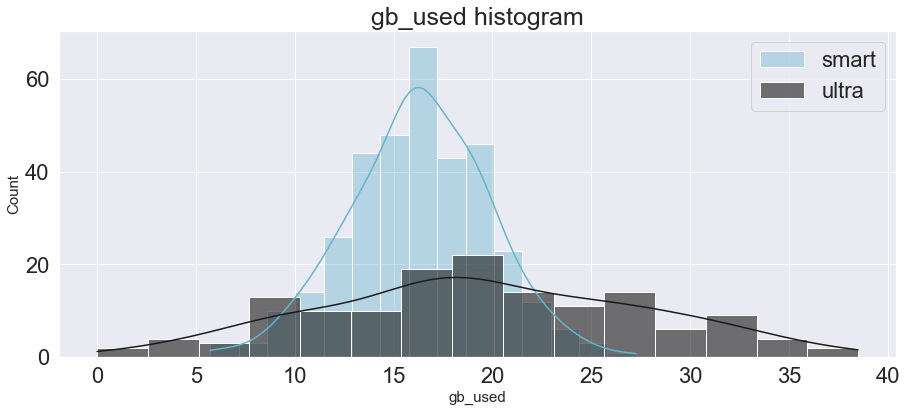

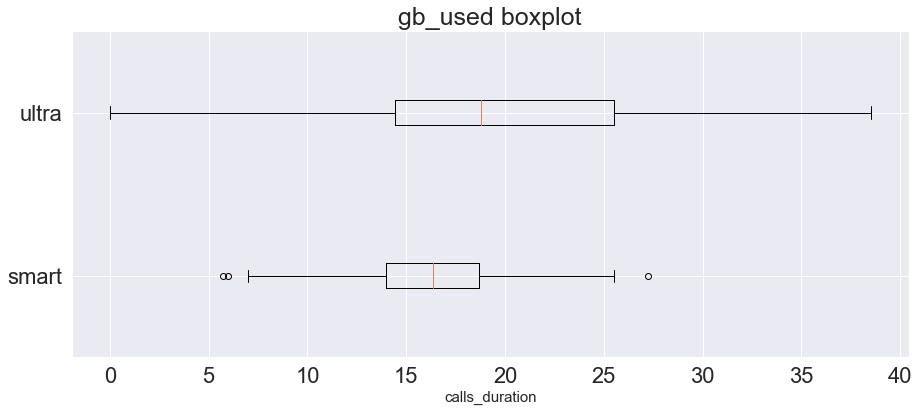

,mean,std,var
tariff,,,
smart,16.33,5.75,33.09
ultra,19.49,9.89,97.82


In [43]:
# посмотрим на данные об интернет-трафике
    
distribution('gb_used')
traffic_distr 

Графики очень похожи на ситуацию с звонками - оба тарифа демонстируют нормальное распределение, распределение тарифа "Ультра" значительно шире за счёт высокого уровня стандартного отклонения, но средние значения тарифов также не имеют значительной разницы. Диаграмма размаха демонстрирует выбросы по обе стороны квартилей для тарифа "Смарт", а значения тарифа "Ультра" целиком находятся в пределах нормального распределения. По сравнению с данными о звонках, распределение тарифа "Смарт" более центрировано относительно распределения "Ультра", что обусловлена более схожим средним показателям.

### Вывод

* Абонентами тарифа "Смарт" являются 70.0% выборки.
* Абонентами тарифа "Ультра" являются 30.0% выборки.

**При сравнении среднемесячных данных о продолжительности звонков, количестве сообщений и объёма трафика в разрезе тарифов были сделаны следующие выводы:**

* несмотря на меньшую долю в выборке, абоненты тарифа "Ультра" намного активнее пользуются услугами оператора.
* пик объёма использованных услуг для обоих тарифов приходится на декабрь, минимальные значения - на январь-февраль
* в январе объём услуг "Ультра" сильно превышает "Смарт" (для части данных - в два раза), в феврале происходит резкий спад, где объёмы услуг для обоих тарифов уравниваются.
* минимальная продолжительность разговора - 200 минут для абонентов "Смарт" и 300 минут для "Ультра".
* минимальное количество отправленных сообщений для обоих тарифов - около 20 сообщений.
* минимальный размер интернет трафика для "Смарт" - 7.5 гб (январь), для "Ультра" - примерно 11 гб (февраль).

Динамика распределения данных по месяцам для звонков и интернет-трафика: 
 * Большая разница в пользу "Ультра" в январе, провал в феврале, где оба показателя на одном уровне, затем относительно равномерное распределение по оставшимся месяцам, с разницей на уровне 20-30% в сторону "Ультра". Пиковым значением для обоих групп является декабрь.
 
Динамика по количеству сообщений:

 * В январе количество сообщений от пользователей "Ультра" больше почти в два раза, тогда как в феврале объём сообщений сопоставим, что также является низшей точкой для обеих групп. Дальше количество сообщений в тарифе "Смарт" находится примерно на одном уровне до конца года, а вот объём сообщений тарифа "Ультра" с каждым месяцем вырастает, постепенно увеличивая разрыв с тарифом "Смарт". Пиком для обоих групп здесь также можно обозначить декабрь (хотя у тарифа "Смарт" идентичный показатель также находится в июне).
 
**При сравнении распределения средних данных по абонентам двух тарифов были сделаны следующие выводы:**

Продолжительность звонков и интернет-сессии:

 * Оба тарифа демонстируют нормальное распределение данных о звонках и интернет-сессиях, но при этом они сильно отличаются по ширине. Это обусловлено высоким уровнем стандартного отклонения и дисперсии у тарифа "Ультра", при том что средние значения тарифов не имеют настолько значительной разницы. 
 * Тариф "Смарт" имеет выбросы по обе стороны границ нормальных значений, а значения тарифа "Ультра" целиком находятся в пределах нормального распределения. Это всё говорит о том, что поведение абонентов "Ультра" намного сложнее предсказать.

Количество сообщений:

 * Оба распределения демонстрируют сильную отрицательную скошенность, визуально напоминают распределение Пуассона. 
 * Средние показатели практически равны стандартному отклонению, что говорит о сильной неравномерности распределения данных. 
 * Оба тарифа также имеются выбросы за пределами верхней границы нормальных значений, в значительно большем объёме для тарифа "Смарт".

<a id='hypothesis'></a>

## Проверка гипотез

Последним этапом исследование является проверка двух сформированных заказчиком гипотез:

* Средняя выручка пользователей тарифов различаются.
* Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

### Различие средней выручки пользователей тарифов

Начнём с анализа распределения общей ежемесячной выручки по пользователям:

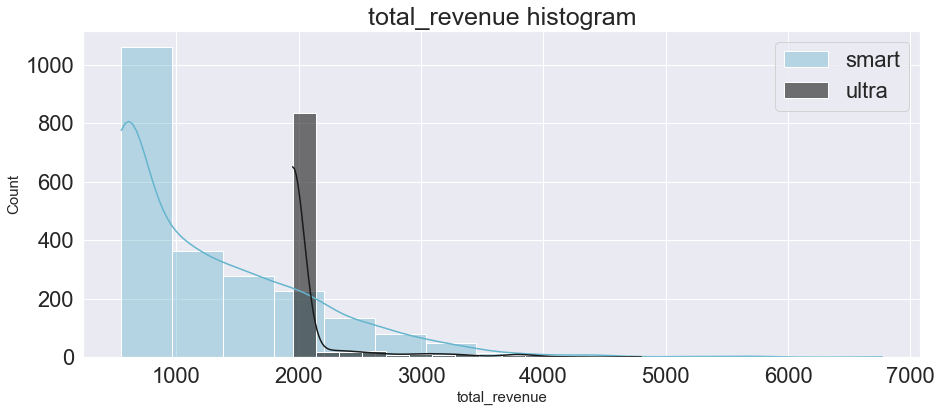

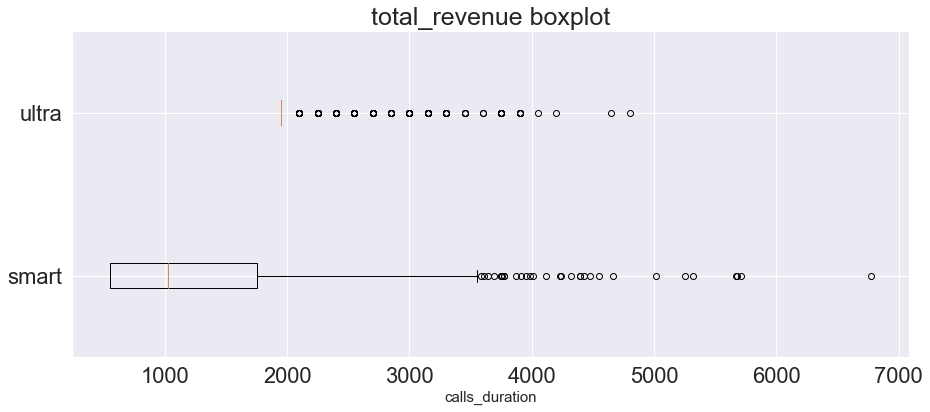

,mean,std,var
tariff,,,
smart,"1,290.89",819.12,"670,957.33"
ultra,"2,070.98",379.42,"143,962.10"


In [44]:
# отберём и сгруппируем необходимые данные из общей таблицы

smart_pivot = (data[data['tariff'] == 'smart']
                 .pivot_table
                 (index=['user_id','month'], values='total_revenue')
                )
ultra_pivot = (data[data['tariff'] == 'ultra']
                 .pivot_table
                 (index=['user_id','month'], values='total_revenue')
                )

revenue_distr = (data
               .pivot_table(index=['tariff'], values='total_revenue', aggfunc=['mean','std', 'var'])
               .droplevel(1, axis=1)
                )

# посмотрим на распределение 

distribution('total_revenue')
revenue_distr

Вспомним условия использования тарифов:

- **Тариф «Смарт»**. Ежемесячная плата: 550 рублей
- **Тариф «Ультра»**. Ежемесячная плата: 1950 рублей

Распределение выручки показывает нам, что пользователи тарифа "Смарт" часто пользуются услугами сверх тарифного пакета - среднее значение более чем в два раза превышает ежемесячный платёж по тарифу. Данные при этом всё равно имеют отрицательную скошенность. 
С пользователями тарифа "Ультра" ситуация другая - абсолютное большинство средних значений как раз находится на уровне суммы ежемесячного платежа по тарифу. Можно сделать обратный вывод для этих пользователей - чаще всего им хватает включенного в пакет объёма услуг связи, выручка в основном не превышает сумму ежемесячного платежа. Представленный объём выбросов не сильно искажает эту картину.

Проверим гипотезу о том, что в общей совокупности средний доход от абонентов обоих тарифов различается. С учётом объёма использования дополнительных услуг сверх пакетов такой исход можно предположить. Несмотря на то, что с точки зрения результатов анализа выборки мы ожидаем больший доход от тарифа "Ультра", в соответствии с ожиданием заказчика необходимо проверить гипотезу в обе стороны. Таким образом:

**Нулевая гипотеза:** 
 * Средняя выручка пользователей тарифов равна.
 
**Альтернативная гипотеза**
 * Средняя выручка пользователей тарифов различаются.
 
Используем инструмент Python для проверки гипотез о равенстве среднего двух независимых генеральных совокупностей по взятым из них выборкам (t-тест):

In [45]:
alpha = .001 # уровень статистической значимости, поставим тысячную процента, чтобы убедится в точности результата

results = st.ttest_ind(smart_pivot.values, ultra_pivot.values, equal_var=False) # у выборок разная дисперсия, уточняем

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: [3.15517321e-245]
Отвергаем нулевую гипотезу


------
**Выводы**

* Абоненты тарифа "Смарт" часто пользуются услугами сверх тарифного пакета - среднее значение более чем в два раза превышает ежемесячный платёж по тарифу. 
* У абонентов "Ультра" в абсолютном большинстве средние значеня находится на уровне суммы ежемесячного платежа по тарифу.
* Проверка гипотезы показала, что вероятность равенства средней выручки общих совокупностей по тарифам составляет меньше 0.001%.

### Различие выручки пользователей из разных регионов

Посчитаем доли абонентов в выборке и рассмотрим распределение выручки:

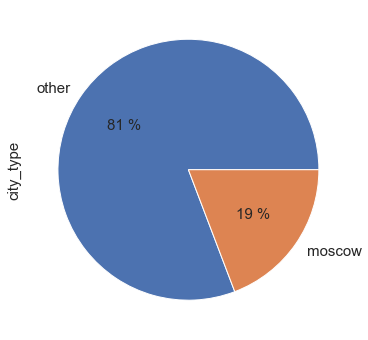

In [46]:
# расчитаём долю регионов в выборке

(
    data['city_type']
    .value_counts()
    .plot(kind='pie', figsize=[15,6], 
          autopct='%1.0f %%', textprops={'fontsize': 15})
)
    
plt.show()

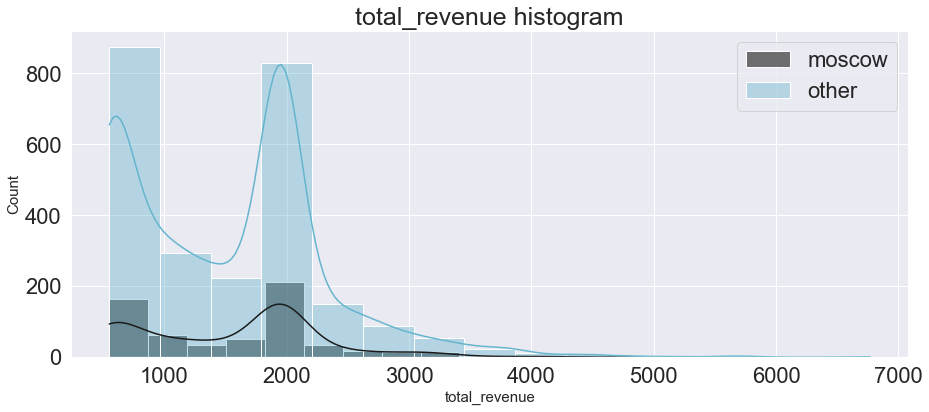

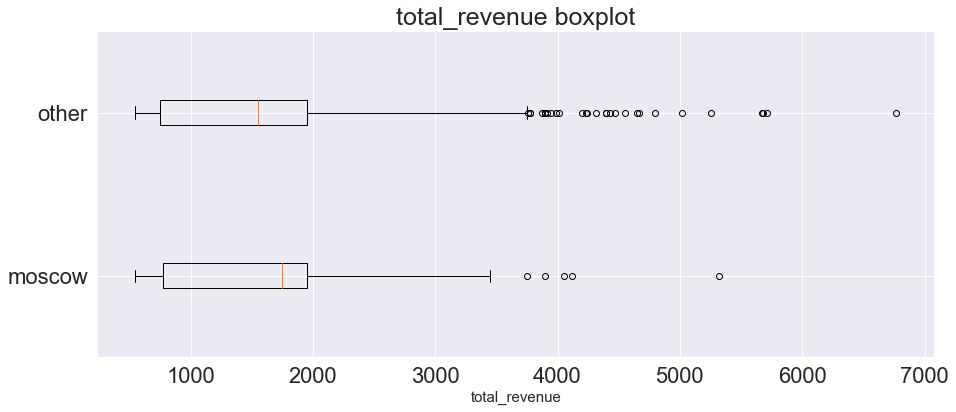

,mean,std,var
city_type,,,
moscow,"1,546.05",752.53,"566,297.76"
other,"1,519.52",811.48,"658,497.80"


In [47]:
# отберём и сгруппируем необходимые данные из общей таблицы

moscow_pivot = (data[data['city_type'] == 'moscow']
                 .pivot_table
                 (index=['user_id','month'], values='total_revenue')
                )
other_pivot = (data[data['city_type'] == 'other']
                 .pivot_table
                 (index=['user_id','month'], values='total_revenue')
                )
revenue_distr = (data
               .pivot_table(index=['city_type'], values='total_revenue', aggfunc=['mean','std', 'var'])
               .droplevel(1, axis=1)
                )

# перезапишем функцию для анализа распределения средних значений.

def distribution(parameter):
    
    moscow = moscow_pivot[parameter]
    other = other_pivot[parameter]    
    
    # строим гистограмму
    
    plt.figure(figsize=[15,6])
    
    sns.histplot(moscow, alpha=0.6, legend=True, 
                 label='moscow', bins=15, color='k', kde=True)
    
    sns.histplot(other, alpha=0.4, legend=True, 
                 label='other', bins=15, color='c', kde=True)
    
    plt.title(parameter + ' ' + 'histogram')
    plt.legend()
    plt.show()
    plt.close()
    
    # строим диаграмму размаха
    plt.figure(figsize=[15,6])
    plt.boxplot([moscow, other], labels=['moscow', 'other'], vert=False)
    plt.title(parameter + ' ' + 'boxplot')
    plt.xlabel('total_revenue')
    plt.show()

    
# посмотрим на распределение 

distribution('total_revenue')
revenue_distr

Оба графика имеют отрицательную скошенность, распределение не похоже на нормальное, много выбросов за пределами третьего квартиля. При этом общая форма графиков очень схожа - это обусловлена формированием пиков на значениях, равным ежемесячному платежу по тарифам - `550` и `1950`. Среднее значение по регионам находятся примерно на одном уровне, как и медиана. 

Проверим гипотезу о том, что в общей совокупности средний доход от абонентов из Москвы отличается от показателей остальных регионов. С учётом того, что большая часть выручки формируется именно размером тарифного платежа, по результатам исследования гипотеза может не подтвердиться.  Таким образом:

**Нулевая гипотеза:** 
 * Средняя выручка пользователей из Москвы равна выручке пользователей из других регионов
 
**Альтернативная гипотеза**
 * Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.
 
Проверка будет осуществлена тем же способом:

In [48]:
alpha = .05 # поставим стандартный уровень статистической значимости

results = st.ttest_ind(moscow_pivot.values, other_pivot.values, equal_var=False) # у выборок разная дисперсия, уточняем

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: [0.44113706]
Не получилось отвергнуть нулевую гипотезу


------
**Выводы**
* Основное распределение значений обоих регионов происходит между ежемесячными платежами по тарифам - `550` и `1950`. 
* Среднее значение по регионам находятся примерно на одном уровне, как и медиана.  

* Проверка гипотезы о равенстве среднего совокупностей выборок по регионам показала, что вероятность равенства составляет около 0.44%, что является выше стандартного уровня статистической значимости.

### Вывод

Анализ распределения выручки между абонентами тарифов показал следующее:
    
* Абоненты тарифа "Смарт" часто пользуются услугами сверх тарифного пакета - среднее значение более чем в два раза превышает ежемесячный платёж по тарифу. 
* У абонентов "Ультра" в абсолютном большинстве средние значеня находится на уровне суммы ежемесячного платежа по тарифу.

Таким образом можно было предположить, что в генеральной совокупности средняя выручка по тарифу "Смарт" могла бы превзойти показатель "Ультра" за счёт выручки за услуги сверх тарифного пакета. Но проверка гипотезы о равенстве среднего совокупностей тарифов показала, что вероятность этого составляет меньше 0.001%. Несмотря на большой объём дополнительных услуг абонентов тарифа "Смарт", вероятность достижения уровня средней выручки абонентов "Ультра" крайне низка.

В ходе анализа выборки абонентов в разрезе регионов были сделаны следующие выводы:

* Абоненты из Москвы составляют 19% выборки.
* Абоненты из других регионов составляют 81% выборки.
* Основное распределение значений обоих регионов происходит между ежемесячными платежами по тарифам - `550` и `1950`. 
* Среднее значение по регионам находятся примерно на одном уровне, как и медиана.  

Проверка гипотезы о равенстве среднего совокупностей выборок по регионам показала, что вероятность равенства составляет около 0.44%, что является выше стандартного уровня статистической значимости. Скорее всего это обусловлено высоким влиянием платежей по тарифам на формирование пиковых значений распределения.

<a id='conclusion'></a>

## Общий вывод

---------

**Рекомендации**

Несмотря на большой объём использования услуг сверх тарифного пакета абонентами "Смарт", абоненты тарифа "Ультра" в среднем приносят больше выручки. Причём это единственный параметр с относительно небольшим распределением - с точки зрения использования услуг абоненты тарифа "Ультра" ведут себя очень непредсказумо, совершенно по разному распоряжаясь своим пакетом включенных услуг. Распределение выручки тарифа "Смарт" частично выходит за рамки среднего показателя "Ультра", другими словами - пользователи более дешёвых тарифов в итоге тратят больше денег на услуги связи. Это может стать хорошим углом для продвижения тарифа внутри клиентской сети.

--------

Целью исследования являлся анализ поведения клиентов на основе выборки данных об активности 500 абонентов за 2018 год и определение наиболее доходного тарифа.

Данные были представлены в виде пяти таблиц, содержащих данные о клиентах: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. При обзоре данных была совершена проверка на возможные ошибки, которые могли помещать исследованию. После была совершена предобработка данных с целью исправления ошибок и обработки пропущенных значений, были изменены типы данных и расчитаны дополнительные параметры. Затем на основе обработанных данных был проведён статистический анализ данных и проверка сформированных заказчиком гипотез.


Каждая таблица была подробно изучена, лишние для исследования данные были удалены, произведены необходимые изменения типов данных. В ходе предобработки были сделаны следующие выводы:

* Средний возраст абонентов - 46 лет
* 7.6% клиентов прекратили пользоваться выбранным тарифом в 2018 году.
* Из тех, кто больше не использует тариф, среднее время использование услуг составляет около 4 месяцев.

* Абоненты, в течении года отказавшиеся от услуг оператора,в зависимости от тарифа ведут себя по разному:
 1. Большинство пользователи тарифа 'Смарт' отказываются от него в первые три месяца использования, пик приходится на второй месяц.
 2. Распределение отказов от тарифа среди пользователей 'Ультра' более равномерно, пик приходится на четвёртый месяц.



* Средняя длительность звонков всех абонентов составляет около 9 минут 
* За период использования тарифа в среднем каждый абонент разговаривает ~2,800 минут.

* В среднем каждый абонент отправляет ~290 сообщений за весь период использования тарифа

* Средний трафик сессии состявляет 0.36 гигабайт.
* Абоненты в период использования тарифа тратят в среднем ~109 гигабайт.

После данные были объединены в единую таблицу `data` и сгруппированы по идентификатору пользователя и месяцам, появившиеся в ходе объединения пропуски были обработаны. Затем были расчитаны дополнительные параметры с объёмом перерасхода тарифного пакета, выручкой по перерасходу и общей выручкой. Таким образом в нашем распоряжении есть данные, показывающие всю информацию в разрезе месяцев для каждого пользователя - именно эта таблица стала основой для дальнейшего исследования.

Дальнейший анализ в основном проводился в разрезе тарифов. Доля абонентов в выборке:

* Абонентами тарифа "Смарт" являются 70.0% выборки.
* Абонентами тарифа "Ультра" являются 30.0% выборки.

**При сравнении среднемесячных данных о продолжительности звонков, количестве сообщений и объёма трафика в разрезе тарифов были сделаны следующие выводы:**

* несмотря на меньшую долю в выборке, абоненты тарифа "Ультра" намного активнее пользуются услугами оператора.
* пик объёма использованных услуг для обоих тарифов приходится на декабрь, минимальные значения - на январь-февраль
* в январе объём услуг "Ультра" сильно превышает "Смарт" (для части данных - в два раза), в феврале происходит резкий спад, где объёмы услуг для обоих тарифов уравниваются.
* минимальная продолжительность разговора - 200 минут для абонентов "Смарт" и 300 минут для "Ультра".
* минимальное количество отправленных сообщений для обоих тарифов - около 20 сообщений.
* минимальный размер интернет трафика для "Смарт" - 7.5 гб (январь), для "Ультра" - примерно 11 гб (февраль).

Динамика распределения данных по месяцам для звонков и интернет-трафика: 
 * Большая разница в пользу "Ультра" в январе, провал в феврале, где оба показателя на одном уровне, затем относительно равномерное распределение по оставшимся месяцам, с разницей на уровне 20-30% в сторону "Ультра". Пиковым значением для обоих групп является декабрь.
 
Динамика по количеству сообщений:

 * В январе количество сообщений от пользователей "Ультра" больше почти в два раза, тогда как в феврале объём сообщений сопоставим, что также является низшей точкой для обеих групп. Дальше количество сообщений в тарифе "Смарт" находится примерно на одном уровне до конца года, а вот объём сообщений тарифа "Ультра" с каждым месяцем вырастает, постепенно увеличивая разрыв с тарифом "Смарт". Пиком для обоих групп здесь также можно обозначить декабрь (хотя у тарифа "Смарт" идентичный показатель также находится в июне).
 
**При сравнении распределения средних данных по абонентам двух тарифов были сделаны следующие выводы:**

Продолжительность звонков и интернет-сессии:

 * Оба тарифа демонстируют нормальное распределение данных о звонках и интернет-сессиях, но при этом они сильно отличаются по ширине. Это обусловлено высоким уровнем стандартного отклонения и дисперсии у тарифа "Ультра", при том что средние значения тарифов не имеют настолько значительной разницы. 
 * Тариф "Смарт" имеет выбросы по обе стороны границ нормальных значений, а значения тарифа "Ультра" целиком находятся в пределах нормального распределения. Это всё говорит о том, что поведение абонентов "Ультра" намного сложнее предсказать.

Количество сообщений:

 * Оба распределения демонстрируют сильную отрицательную скошенность, визуально напоминают распределение Пуассона. 
 * Средние показатели практически равны стандартному отклонению, что говорит о сильной неравномерности распределения данных. 
 * Оба тарифа также имеются выбросы за пределами верхней границы нормальных значений, в значительно большем объёме для тарифа "Смарт".
 
**Анализ распределения выручки между абонентами тарифов показал следующее**:
    
* Абоненты тарифа "Смарт" часто пользуются услугами сверх тарифного пакета - среднее значение более чем в два раза превышает ежемесячный платёж по тарифу. 
* У абонентов "Ультра" в абсолютном большинстве средние значеня находится на уровне суммы ежемесячного платежа по тарифу.

Таким образом можно было предположить, что в генеральной совокупности средняя выручка по тарифу "Смарт" могла бы превзойти показатель "Ультра" за счёт выручки за услуги сверх тарифного пакета. Но проверка гипотезы о равенстве среднего совокупностей тарифов показала, что вероятность этого составляет меньше 0.001%. Несмотря на большой объём дополнительных услуг абонентов тарифа "Смарт", вероятность достижения уровня средней выручки абонентов "Ультра" крайне низка.

В ходе анализа выборки абонентов в разрезе регионов были сделаны следующие выводы:

* Абоненты из Москвы составляют 19% выборки.
* Абоненты из других регионов составляют 81% выборки.
* Основное распределение значений обоих регионов происходит между ежемесячными платежами по тарифам - `550` и `1950`. 
* Среднее значение по регионам находятся примерно на одном уровне, как и медиана.  

Проверка гипотезы о равенстве среднего совокупностей выборок по регионам показала, что вероятность равенства составляет около 0.44%, что является выше стандартного уровня статистической значимости. Скорее всего это обусловлено высоким влиянием платежей по тарифам на формирование пиковых значений распределения.

<a id='benefit'></a>